In [1]:
import basis_set_exchange as bse
import scipy as sp
import matplotlib.pyplot as plt
from pyscf import gto,scf
import copy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from pyscf.data.elements import _symbol
from numpy.linalg import norm

In [2]:
import sys
sys.path.append("./Libs")
from FcMole import FcM
from FDcoeffs import get_coeffs

In [5]:
n_321g=gto.basis.load(bse.get_basis("def2-tzvp",fmt="nwchem",elements=["N"]),"N")
c_321g=gto.basis.load(bse.get_basis("def2-tzvp",fmt="nwchem",elements=["C"]),"C")
n_321g,"*******************",c_321g

([[0,
   [19730.800647, 0.00021887984991],
   [2957.8958745, 0.0016960708803],
   [673.22133595, 0.0087954603538],
   [190.68249494, 0.035359382605],
   [62.295441898, 0.11095789217],
   [22.654161182, 0.24982972552]],
  [0, [8.9791477428, 0.40623896148], [3.686300237, 0.24338217176]],
  [0, [0.84660076805, 1.0]],
  [0, [0.33647133771, 1.0]],
  [0, [0.13647653675, 1.0]],
  [1,
   [49.20038051, 0.0055552416751],
   [11.346790537, 0.038052379723],
   [3.4273972411, 0.14953671029],
   [1.1785525134, 0.3494930523]],
  [1, [0.41642204972, 0.45843153697]],
  [1, [0.14260826011, 0.24428771672]],
  [2, [1.654, 1.0]],
  [2, [0.469, 1.0]],
  [3, [1.093, 1.0]]],
 '*******************',
 [[0,
   [13575.349682, 0.00022245814352],
   [2035.233368, 0.0017232738252],
   [463.22562359, 0.0089255715314],
   [131.20019598, 0.035727984502],
   [42.853015891, 0.11076259931],
   [15.584185766, 0.24295627626]],
  [0, [6.2067138508, 0.41440263448], [2.5764896527, 0.23744968655]],
  [0, [0.57696339419, 1.0]],


In [8]:
def g321(z,ref=None):
    if z <1.e-10: raise Exception("non implemented Zero charge atom")
    if z%1 <1.e-10:
        return gto.basis.load(bse.get_basis("def2-tzvp",fmt="nwchem",elements=[int(z)]),_symbol(int(z)))
    elif ref:
        rb=g321(ref)
        rbm=g321(ref-1)
        rbp=g321(ref+1)
        fb=copy.deepcopy(rb)
        for i in range(len(fb)):  
            for j in range(1,len(fb[i])):
                for k in range(len(fb[i][j])):
                    a=(rbp[i][j][k]-rbm[i][j][k])/2
                    b=(rbp[i][j][k]+rbm[i][j][k]-2*rb[i][j][k])
                    fb[i][j][k]+=a*(z-ref)+b*(z-ref)**2
        return fb
    else: raise Exception("can't get the fractional charge basis set, frac val and no ref")

In [9]:
g321(6,ref=6),"**********",g321(6.5,ref=6),"**********",g321(7,ref=6)

([[0,
   [13575.349682, 0.00022245814352],
   [2035.233368, 0.0017232738252],
   [463.22562359, 0.0089255715314],
   [131.20019598, 0.035727984502],
   [42.853015891, 0.11076259931],
   [15.584185766, 0.24295627626]],
  [0, [6.2067138508, 0.41440263448], [2.5764896527, 0.23744968655]],
  [0, [0.57696339419, 1.0]],
  [0, [0.22972831358, 1.0]],
  [0, [0.095164440028, 1.0]],
  [1,
   [34.697232244, 0.0053333657805],
   [7.9582622826, 0.035864109092],
   [2.3780826883, 0.14215873329],
   [0.81433208183, 0.34270471845]],
  [1, [0.28887547253, 0.46445822433]],
  [1, [0.10056823671, 0.24955789874]],
  [2, [1.097, 1.0]],
  [2, [0.318, 1.0]],
  [3, [0.761, 1.0]]],
 '**********',
 [[0,
   [16653.0751645, 0.000220668996715],
   [2496.56462125, 0.00170967235275],
   [568.22347977, 0.008860515942600001],
   [160.94134545999998, 0.0355436835535],
   [52.574228894499996, 0.11086024574],
   [19.119173474, 0.24639300089]],
  [0,
   [7.5929307968, 0.41032079798],
   [3.1313949448500003, 0.24041592915499

In [10]:
def E(l,zbs=True):
    if zbs:
        mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7-l,ref=7),"N2":g321(7+l,ref=7)},verbose=1)
    else:
         mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7,ref=7),"N2":g321(7,ref=7)},verbose=1)       
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return e

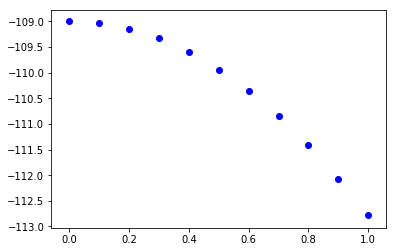

In [11]:
for i in np.linspace(0,1,11):
    plt.scatter(i,E(i),color="blue")

In [12]:
eT_R=E(-1,zbs=False)

In [13]:
e_co=scf.RHF(gto.M(atom="C 0 0 0; O 0 0 2.05",unit="Bohrs",basis=bse.get_basis("def2-tzvp"\
                                                       ,fmt="nwchem",elements=["C","N","O"]))).scf()
e_nn=scf.RHF(gto.M(atom="N 0 0 0; N 0 0 2.05",unit="Bohrs",basis=bse.get_basis("def2-tzvp"\
                                                       ,fmt="nwchem",elements=["C","N","O"]))).scf()

converged SCF energy = -112.786211595028
converged SCF energy = -108.990225181121


In [14]:
#5pts finite difference coefficients
fd1=np.asarray([1/12,-2/3 ,0,2/3,-1/12])
fd2=np.asarray([-1/12,4/3,-5/2,4/3,-1/12])
fd3=np.asarray([-1/2,1,0,-1,1/2])
fd4=np.asarray([1,-4,6,-4,1])
fds=[fd1,fd2,fd3,fd4]
fds5=get_coeffs(5)
fds7=get_coeffs(7)

In [15]:
dl=.1
Es=np.asarray([E(-3*dl),E(-2*dl),E(-dl),e_nn,E(dl),E(2*dl),E(3*dl)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(fds7[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft,e_co,inc

([-108.99022518112065,
  -108.99022518112204,
  -112.79279157628936,
  -112.79279157621683,
  -112.77318868979161,
  -112.77318869048439,
  -112.83264328736469],
 -112.78621159502818,
 [-1.3944401189291966e-12,
  -3.8025663951673163,
  7.253457094217687e-11,
  0.019602886425218454,
  -6.927791673660975e-10,
  -0.05945459688029408])

In [16]:
dl=.1
Es=np.asarray([E(-2*dl),E(-dl),e_nn,E(dl),E(2*dl)])
apdft=[e_nn]
inc=[]
for i in range(4):
    inc.append(fds5[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+fds5[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1) )
apdft,e_co,inc

([-108.99022518112065,
  -108.9902251811204,
  -112.79276779446073,
  -112.79276779444889,
  -112.77613763757657],
 -112.78621159502818,
 [2.4868995751603507e-13,
  -3.802542613340342,
  1.1842378929335e-11,
  0.0166301568723289])

In [17]:
dl=.05
Es=np.asarray([E(-3*dl,zbs=False),E(-2*dl,zbs=False),E(-dl,zbs=False),e_nn,E(dl,zbs=False),E(2*dl,zbs=False),E(3*dl,zbs=False)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(fds7[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+fds7[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1) )
apdft,eT_R,e_co,inc

([-108.99022518112065,
  -108.99022518112037,
  -112.70692857778245,
  -112.70692857790797,
  -112.69258651692914,
  -112.6925865121922,
  -112.69292358482373],
 -112.6929256381206,
 -112.78621159502818,
 [2.7977620220553945e-13,
  -3.716703396662079,
  -1.25529216650951e-10,
  0.014342060978833613,
  4.736951571734e-09,
  -0.00033707263153499086])

In [18]:
def E_cn(l,zbs=True):
    if zbs:
        mol_l=FcM(fcs=[-l,0],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7-l,ref=7),"N2":g321(7)},verbose=1)
    elif not zbs:
        mol_l=FcM(fcs=[-l,0],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7,ref=7),"N2":g321(7)},verbose=1)
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return e

In [26]:
mf_cn=scf.RHF(gto.M(atom="C 0 0 0; N 0 0 2.05",unit="Bohrs",basis=bse.get_basis("def2-tzvp"\
                                                       ,fmt="nwchem",elements=["C","N","O"]),charge=-1))
e_cn=mf_cn.scf()

converged SCF energy = -92.3311381205634


In [27]:
dl=.1
Es=np.asarray([E_cn(-3*dl),E_cn(-2*dl),E_cn(-dl),e_nn,E_cn(dl),E_cn(2*dl),E_cn(3*dl)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,i',fds7[i+1],Es)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft=np.asarray(apdft)
apdft,e_cn,apdft-e_cn,inc

(array([-108.99022518,  -90.71384198,  -92.36873439,  -92.32823196,
         -92.32992828,  -92.32966556,  -92.33027783]),
 -92.33113812056337,
 array([-1.66590871e+01,  1.61729614e+00, -3.75962660e-02,  2.90615936e-03,
         1.20983821e-03,  1.47255809e-03,  8.60294548e-04]),
 [18.276383197856383,
  -1.6548924032765864,
  0.04050242533656007,
  -0.0016963211516933063,
  0.0002627198843659546,
  -0.0006122635435682845])

In [28]:
dl=.1
Es=np.asarray([E_cn(-3*dl,zbs=False),E_cn(-2*dl,zbs=False),E_cn(-dl,zbs=False),e_nn,E_cn(dl,zbs=False),E_cn(2*dl,zbs=False),E_cn(3*dl,zbs=False)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,i',fds7[i+1],Es)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft=np.asarray(apdft)
apdft,E_cn(1,zbs=False),e_cn,apdft-E_cn(1,zbs=False),apdft-e_cn,inc

(array([-108.99022518,  -90.71483653,  -92.32627163,  -92.2914705 ,
         -92.28796925,  -92.28913923,  -92.28907515]),
 -92.28904306800459,
 -92.33113812056337,
 array([-1.67011821e+01,  1.57420654e+00, -3.72285657e-02, -2.42742810e-03,
         1.07382148e-03, -9.61590163e-05, -3.20785617e-05]),
 array([-1.66590871e+01,  1.61630159e+00,  4.86648683e-03,  3.96676245e-02,
         4.31688740e-02,  4.19988935e-02,  4.20629740e-02]),
 [18.275388649232564,
  -1.6114351018422954,
  0.0348011376220351,
  0.003501249585073177,
  -0.0011699804976691057,
  6.408045452291033e-05])

In [29]:
#check if basis are orthonormal
#They are